In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [6]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [7]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [9]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}


# Stochastic Gradient Descent

In [10]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [11]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [20]:
par,loss=inference.fit(epochs=100,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


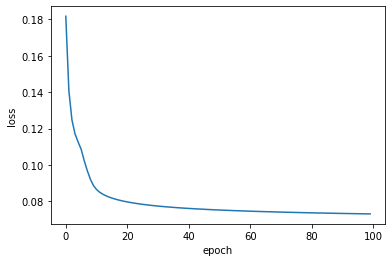

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [22]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [23]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [24]:
samples=np.asarray(samples)

In [25]:
samples.shape

(100, 14000)

In [26]:
y_hat=np.quantile(samples,.5,axis=0)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1415
           1       0.95      0.95      0.95      1588
           2       0.87      0.85      0.86      1387
           3       0.84      0.85      0.85      1430
           4       0.87      0.87      0.87      1335
           5       0.83      0.80      0.81      1281
           6       0.91      0.94      0.93      1342
           7       0.88      0.90      0.89      1444
           8       0.79      0.81      0.80      1357
           9       0.85      0.83      0.84      1421

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



In [28]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [29]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

# Stochastic Gradient Langevin Dynamics

In [50]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [51]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [52]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [53]:
par,loss,posterior_samples=inference.fit(epochs=100,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


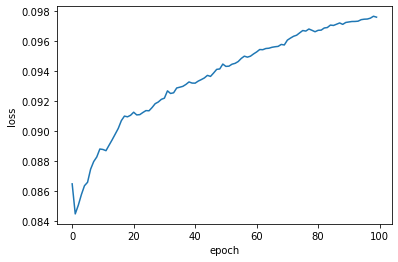

In [54]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [45]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [46]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1415
           1       0.95      0.95      0.95      1588
           2       0.86      0.86      0.86      1387
           3       0.86      0.85      0.86      1430
           4       0.87      0.90      0.88      1335
           5       0.81      0.78      0.80      1281
           6       0.90      0.94      0.92      1342
           7       0.87      0.91      0.89      1444
           8       0.83      0.81      0.82      1357
           9       0.86      0.83      0.84      1421

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.87     14000
weighted avg       0.88      0.88      0.88     14000



# Posterior Diagnostics

In [61]:
import arviz as az

In [81]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [82]:
posterior_samples_numpy['bias'].shape

(1, 100, 10)

In [83]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [85]:
ess=az.ess(dataset)

In [89]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 100.0 100.0 ... 100.0
    bias           (bias_dim_0) float64 100.0 100.0 100.0 ... 100.0 100.0 100.0